In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, save_model
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from tensorflow.keras.applications import *
from efficientnet.tfkeras import *
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import resample

In [2]:
# General settings
BATCH_SIZE = 32
IMG_SIZE = 224
auto = tf.data.experimental.AUTOTUNE
n_epochs = 600

In [3]:
df = pd.read_csv("trainLabels_cropped.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1


In [4]:
df["image"] = df["image"].apply(lambda x: x+".jpeg")
df.head()

,Unnamed: 0,Unnamed: 0.1,image,level
0,0,0,10_left.jpeg,0
1,1,1,10_right.jpeg,0
2,2,2,13_left.jpeg,0
3,3,3,13_right.jpeg,0
4,4,4,15_left.jpeg,1


0    25802
2     5288
1     2438
3      872
4      708
Name: level, dtype: int64

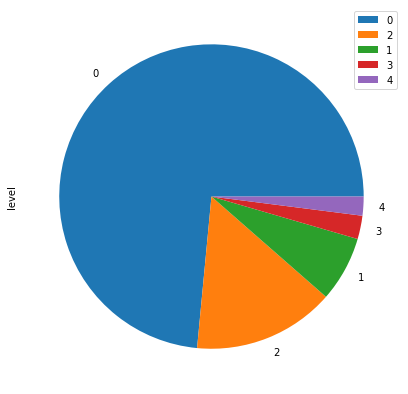

In [5]:
df["level"].value_counts().plot(kind="pie", figsize=(7,7))
plt.legend()
df["level"].value_counts()

# Helper functions

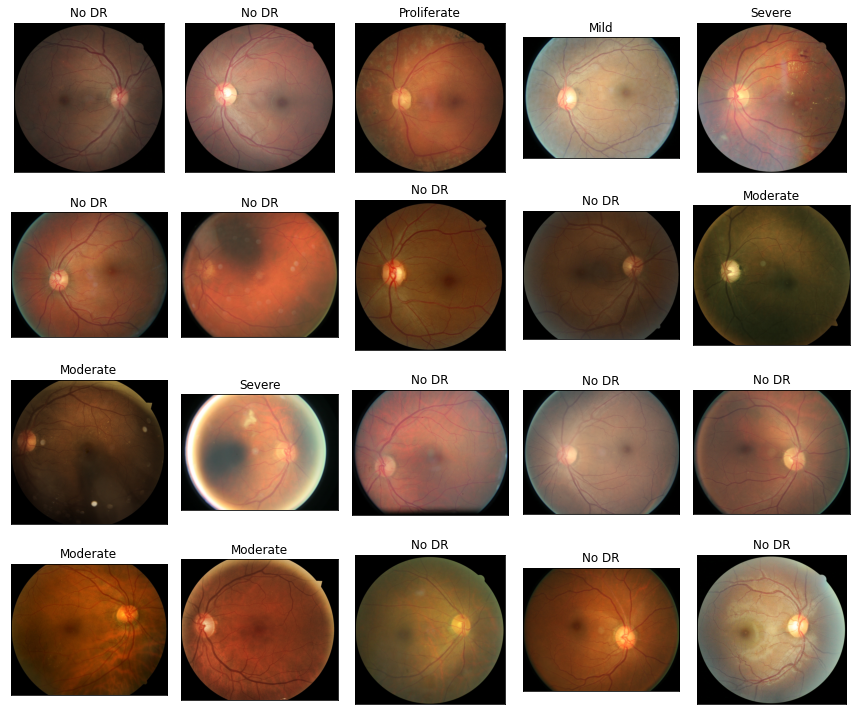

In [8]:
# Visualize a random sample of our images
labels = ["No DR", "Mild", "Moderate","Severe", "Proliferate"]
image_paths = os.listdir("./resized_train_cropped/resized_train_cropped/")

def show_random_images(num=4):
    plt.figure(figsize=(12,10))
    
    for n in range(num):
        selection = np.random.randint(0, df.shape[0]+1)
        img_path = os.path.join("./resized_train_cropped/resized_train_cropped/", image_paths[selection])
        label = image_paths[selection]
        label = df.loc[df["image"] == label]["level"].values[0]
        label = labels[label]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0,0), 10), -4, 128)
        plt.subplot(4, 5, n+1, xticks=[], yticks=[])
        plt.imshow(img)
        plt.title(label)
    
    plt.tight_layout()

show_random_images(20)

In [44]:
# Functions to preprocess our data

def read_image(path, label):
    """
    Function designed to read in and preprocess images
    """
    bits = tf.io.read_file(path)
    img = tf.io.decode_jpeg(bits,3)
    img = tf.cast(img, tf.float32) / 255.
    img = tf.image.resize(img, (IMG_SIZE,IMG_SIZE))
    return img, label
    

def augment_data(img, label):
    """
    Basic data augmentation
    """
    img = tf.image.random_flip_left_right(img) 
    img = tf.image.random_flip_left_right(img)
    img = tf.image.rot90(img, k=4)
    return img, label

In [45]:
def get_model(which="mobilenet", dense=False, img_size=(IMG_SIZE,IMG_SIZE,3)):
    """
    Parameters:
    dense - (bool) If True, makes the top layer (classifier) a fully-connected dense layer (default). If False the top layer is a global average pooling layer.

    which - (String) {Options:  mobilenet=MobileNetV2(default), incepresnet=InceptionResNetV2, densenet=DenseNet201, effnet=EfficientNetB7} (case-insensitive) which model to use as the base classifier

    img_size - (Tuple) Size of input images
        
    Returns a model
    
    """
    # Choosing which model to use as our base
    which = which.lower()
    
    if which=="incepresnet":
        base = InceptionResNetV2(input_shape=(img_size), include_top=False, weights="imagenet")
    elif which=="densenet":
        base = DenseNet121(input_shape=(img_size), include_top=False, weights="imagenet")
    elif which=="effnet":
        base = EfficientNetB(input_shape=(img_size), include_top=False, weights="imagenet")
    else: 
        base = MobileNetV2(input_shape=(img_size), include_top=False, weights="imagenet")
    
    # Choosing the top for our model
    if dense:
        flatten = Flatten()
        fc1 = Dense(512, activation="relu")
        fc2 = Dense(BATCH_SIZE, activation="relu")
        model = Sequential([
            base,
            flatten,
            fc1,
            fc2
        ])
    else:
        GAP = GlobalAveragePooling2D()
        dropout = Dropout(0.5)
        model = Sequential([base, dropout, GAP])
    
    output = Dense(5, activation="softmax")
    model.add(output)
    
    optimizer = tf.keras.optimizers.Adam(1e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    
    model.compile(loss=loss, optimizer=optimizer, metrics=["acc"])
    model.summary()
    return model

In [46]:
# Original train test split
img_dir = "./resized_train_cropped/resized_train_cropped/"
paths = df["image"].apply(lambda path: img_dir + path)
labels = df["level"].values

train_paths, test_paths, train_labels, test_labels = train_test_split(paths.values, labels, 
                                                                      test_size=0.33, random_state=1996)
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels, 
                                                                       test_size=0.15, random_state=1996)

In [47]:
# Creating dataset objects for training
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    # Read image path, (num_parallel_calls is how many to do in parallel based on cpu)
    .map(read_image, num_parallel_calls=auto)
    .apply(tf.data.experimental.ignore_errors())
    # Repeat our dataset an indefinite amount of times
    .repeat()
    # Perform data augmentation
    .map(augment_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Shuffle the individual (image, label) pairs for each pair
    .shuffle(BATCH_SIZE)
    # How many images to bring in at once
    .batch(BATCH_SIZE)
    # Prepares data while the current batch is being processed. prefetch(2) will prepare 2 datasets of BATCH_SIZE images
    .prefetch(tf.data.experimental.AUTOTUNE)
    )

valid_ds = (
    tf.data.Dataset.from_tensor_slices((valid_paths, valid_labels))
    .map(read_image, num_parallel_calls=auto)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(auto)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    .map(read_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# Creating resampled datasets

In [48]:
# New dataframe for explicit resampling
train_paths_df = pd.DataFrame(train_paths, columns=["path"])
train_labels_df = pd.DataFrame(train_labels, columns=["level"])
train_df = pd.concat([train_paths_df, train_labels_df], axis=1)
num_to_sample = 14620
over_sample = train_df[train_df["level"]==0]

class_1 = train_df[train_df["level"]==1]
class_2 = train_df[train_df["level"]==2]
class_3 = train_df[train_df["level"]==3]
class_4 = train_df[train_df["level"]==4]
classes = [class_1, class_2, class_3, class_4]

for c in classes:
    over_sampled = c.sample(n=num_to_sample, replace=True, random_state=96)
    over_sample = pd.concat([over_sample, over_sampled])
    
over_sample["level"].value_counts()

4    14620
3    14620
2    14620
1    14620
0    14620
Name: level, dtype: int64

In [49]:
oversampled_train_paths = over_sample["path"].values
oversampled_train_labels = over_sample["level"].values

# Make dataset object from oversampled classes

oversampled__train_ds = (
    tf.data.Dataset.from_tensor_slices((oversampled_train_paths, oversampled_train_labels))
    .map(read_image, num_parallel_calls=auto)
    .repeat()
    .shuffle(BATCH_SIZE)
    .map(augment_data, num_parallel_calls=auto)
    .batch(BATCH_SIZE)
    .prefetch(auto)
    )

In [50]:
# Resampling all classes to provide 708 samples each
num_to_sample = df["level"].value_counts()[4]
new_samples = pd.DataFrame()

class_0 = train_df[train_df["level"]==0]
class_1 = train_df[train_df["level"]==1]
class_2 = train_df[train_df["level"]==2]
class_3 = train_df[train_df["level"]==3]
class_4 = train_df[train_df["level"]==4]
classes = [class_0, class_1, class_2, class_3, class_4]

for i, c in enumerate(classes):
    if c["level"].value_counts()[i] < num_to_sample:
        oversampled = c.sample(n=num_to_sample, replace=True, random_state=96)
        new_samples = pd.concat([new_samples, oversampled])
    else:
        undersampled = c.sample(n=num_to_sample, replace=False, random_state=97)
        new_samples = pd.concat([new_samples, undersampled])
    
new_samples["level"].value_counts()

3    708
1    708
4    708
2    708
0    708
Name: level, dtype: int64

In [51]:
# Shuffle dataframe
new_samples = new_samples.sample(frac=1, random_state=69)
newly_sampled_paths = new_samples["path"].values
newly_sampled_train_labels = new_samples["level"].values

rs_train_paths, rs_val_paths, rs_train_lbs, rs_val_lbs = train_test_split(newly_sampled_paths, newly_sampled_train_labels,
                                                                         test_size=0.15, random_state=42)

# Make dataset object from oversampled classes

new_train_ds = (
    tf.data.Dataset.from_tensor_slices((rs_train_paths, rs_train_lbs))
    .map(read_image, num_parallel_calls=auto)
    .map(augment_data, num_parallel_calls=auto)
    .repeat()
    .shuffle(128)
    .batch(BATCH_SIZE)
    .prefetch(auto)
    )

new_valid_ds = (
    tf.data.Dataset.from_tensor_slices((rs_val_paths, rs_val_lbs))
    .map(read_image, num_parallel_calls=auto)
    .batch(BATCH_SIZE)
    .prefetch(auto)
)

# Testing multiple models

In [52]:
# Training parameters and callbacks
STEPS = len(train_paths) // (4*BATCH_SIZE)
reduce_lr  = tf.keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

# Setting up class weights
freq = [(1 - df["level"].value_counts()[i] / len(df)) for i in range(5)]
class_weights = {
    0: freq[0],
    1: freq[1],
    2: freq[2],
    3: freq[3],
    4: freq[4]
}

## MobileNet

In [16]:
# MobilenetV2 with Global Average Pooling 
mobile = get_model("mobilenet", False, img_size=(IMG_SIZE, IMG_SIZE, 3))

H = mobile.fit(train_ds, validation_data=valid_ds, batch_size=BATCH_SIZE, 
          steps_per_epoch=STEPS, epochs=n_epochs, callbacks=[early_stop, reduce_lr], class_weight=class_weights)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1280)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/600
49/49 [==============================] - 66s 1s/step - loss: 0.5549 - acc: 0.5976 - val_loss: 2.4067 - val_acc: 0.7285 - lr: 0.0010
Epoch 2/600
49/49 [==============================] - 45s 912ms/step - loss: 0.4834 - acc: 0.695

In [11]:
model = get_model("mobilenet", False, img_size=(IMG_SIZE, IMG_SIZE, 3))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1280)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_________________________________________________________________


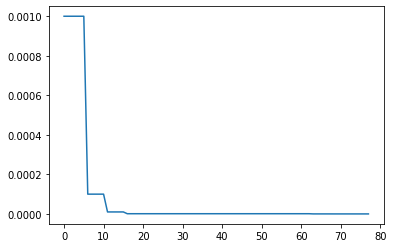

In [17]:
pd.DataFrame(H.history)["lr"].plot()

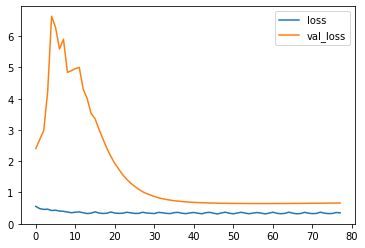

In [18]:
pd.DataFrame(H.history)[["loss", "val_loss"]].plot()

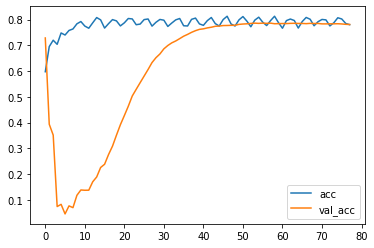

In [19]:
pd.DataFrame(H.history)[["acc", "val_acc"]].plot()

In [20]:
print(classification_report(valid_labels, model.predict_classes(valid_ds)))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      2572
           1       0.27      0.03      0.06       245
           2       0.55      0.54      0.55       550
           3       0.55      0.30      0.39        94
           4       0.62      0.49      0.55        68

    accuracy                           0.79      3529
   macro avg       0.57      0.46      0.48      3529
weighted avg       0.75      0.79      0.76      3529



In [21]:
print(classification_report(test_labels, model.predict_classes(test_ds)))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      8610
           1       0.21      0.02      0.04       770
           2       0.51      0.53      0.52      1721
           3       0.55      0.25      0.34       286
           4       0.63      0.48      0.55       199

    accuracy                           0.79     11586
   macro avg       0.55      0.44      0.47     11586
weighted avg       0.75      0.79      0.76     11586



In [22]:
cm = confusion_matrix(test_labels, model.predict_classes(test_ds))

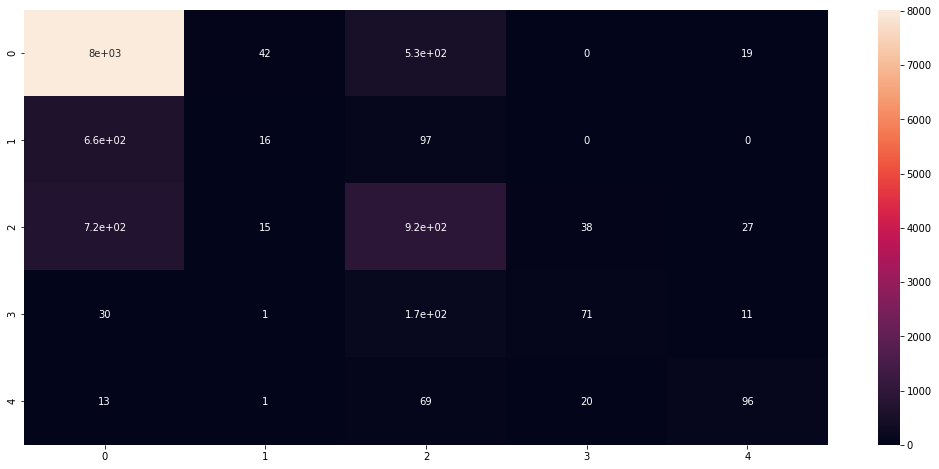

In [23]:
plt.figure(figsize=(18,8))
sns.heatmap(cm, annot=True)

## EfficientNetB1 (Because of resource constraints)

In [28]:
STEPS = len(train_paths) // (BATCH_SIZE)
effnet = get_model("effnet", dense=False, img_size=(IMG_SIZE, IMG_SIZE, 3))

H = effnet.fit(train_ds, validation_data=valid_ds, batch_size=BATCH_SIZE, 
          steps_per_epoch=STEPS, epochs=n_epochs, callbacks=[early_stop, reduce_lr], class_weight=class_weights)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Model)      (None, 7, 7, 1280)        6575232   
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 1280)        0         
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 6405      
Total params: 6,581,637
Trainable params: 6,519,589
Non-trainable params: 62,048
_________________________________________________________________
Epoch 1/600
624/624 [==============================] - 269s 432ms/step - loss: 0.6404 - acc: 0.4806 - val_loss: 1.1524 - val_acc: 0.6092 - lr: 1.0000e-05
Epoch 2/600
624/624 [==============================] - 271s 434ms/step - loss: 0.54

In [29]:
print(classification_report(valid_labels, model.predict_classes(valid_ds)))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2572
           1       0.16      0.11      0.13       245
           2       0.45      0.52      0.48       550
           3       0.49      0.37      0.42        94
           4       0.49      0.59      0.53        68

    accuracy                           0.73      3529
   macro avg       0.49      0.49      0.48      3529
weighted avg       0.72      0.73      0.72      3529



In [30]:
print(classification_report(test_labels, model.predict_classes(test_ds)))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      8610
           1       0.12      0.09      0.10       770
           2       0.43      0.53      0.47      1721
           3       0.49      0.36      0.42       286
           4       0.45      0.54      0.49       199

    accuracy                           0.73     11586
   macro avg       0.47      0.47      0.47     11586
weighted avg       0.73      0.73      0.73     11586



## DenseNet 121

In [56]:
dnet = get_model("densenet")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 1024)        0         
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [61]:
dnet_stop = EarlyStopping(patience=8, restore_best_weights=True)
dnet_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
dH = dnet.fit(train_ds, epochs=n_epochs, class_weight=class_weights, steps_per_epoch=STEPS*4,
          validation_data=valid_ds, initial_epoch=11,callbacks=[dnet_stop, dnet_reduce_lr])

Epoch 12/600
624/624 [==============================] - 231s 370ms/step - loss: 0.1364 - acc: 0.9301 - val_loss: 0.7682 - val_acc: 0.7370 - lr: 1.0000e-06
Epoch 13/600
624/624 [==============================] - 226s 363ms/step - loss: 0.1333 - acc: 0.9286 - val_loss: 0.7662 - val_acc: 0.7370 - lr: 1.0000e-06
Epoch 14/600
624/624 [==============================] - 222s 355ms/step - loss: 0.1290 - acc: 0.9333 - val_loss: 0.7689 - val_acc: 0.7407 - lr: 1.0000e-06
Epoch 15/600
624/624 [==============================] - 221s 354ms/step - loss: 0.1238 - acc: 0.9378 - val_loss: 0.7719 - val_acc: 0.7436 - lr: 1.0000e-06
Epoch 16/600
624/624 [==============================] - ETA: 0s - loss: 0.1213 - acc: 0.9388
Epoch 00016: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
624/624 [==============================] - 223s 357ms/step - loss: 0.1213 - acc: 0.9388 - val_loss: 0.7742 - val_acc: 0.7450 - lr: 1.0000e-06
Epoch 17/600
624/624 [==============================] - 222s 355m